# Bitcoin Price Prediction

One note at the start: I struggled with conda environments and setting it up to use the same packages as specified in `spec-file.txt`, so I ended up just using the package versions I already had installed, as specified in `requirements.txt`. 

In [1]:
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2022-07-01 00:06:09.396377: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-01 00:06:09.396396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
data = pd.read_csv('bitcoin.csv').drop(['time_period_start', 'time_period_end', 'time_open', 'time_close'], axis=1)
data.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,7165.72,7165.72,7165.71,7165.71,0.021841,2
1,7168.30,7168.30,7168.30,7168.30,1.000000,2
2,7170.50,7170.50,7170.50,7170.50,0.002000,1
3,7169.20,7169.20,7169.20,7169.20,0.004000,2
4,7169.20,7169.20,7169.20,7169.20,0.002000,1


## Lookback Window

In order to capture the past as features, we create the below function. It takes as input some number of seconds to look back, defaulted to 60 seconds.

In [3]:
def lookback(dataset, timesteps = 60):
    # this uses the shift method of pandas dataframes to shift all of the columns down one row
    # and then append to the original dataset
    data = dataset
    for i in range(1, timesteps):
        step_back = dataset.shift(i).reset_index()
        step_back.columns = ['index'] + [f'{column}_-{i}' for column in dataset.columns if column != 'index']
        data = data.reset_index().merge(step_back, on='index', ).drop('index', axis=1)
        
    return data.dropna()
        
features = lookback(data)

In [4]:
features.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count,price_open_-1,price_high_-1,price_low_-1,price_close_-1,...,price_low_-58,price_close_-58,volume_traded_-58,trades_count_-58,price_open_-59,price_high_-59,price_low_-59,price_close_-59,volume_traded_-59,trades_count_-59
59,7154.97,7154.97,7154.97,7154.97,2.000000,2,7163.30,7163.30,7163.30,7163.30,...,7168.30,7168.3,1.000000,2.0,7165.72,7165.72,7165.71,7165.71,0.021841,2.0
60,7161.20,7163.40,7161.20,7163.40,0.015800,2,7154.97,7154.97,7154.97,7154.97,...,7170.50,7170.5,0.002000,1.0,7168.30,7168.30,7168.30,7168.30,1.000000,2.0
61,7154.98,7154.98,7154.97,7154.98,0.038357,3,7161.20,7163.40,7161.20,7163.40,...,7169.20,7169.2,0.004000,2.0,7170.50,7170.50,7170.50,7170.50,0.002000,1.0
62,7154.98,7154.98,7154.98,7154.98,0.032201,1,7154.98,7154.98,7154.97,7154.98,...,7169.20,7169.2,0.002000,1.0,7169.20,7169.20,7169.20,7169.20,0.004000,2.0
63,7154.97,7154.97,7154.97,7154.97,2.000000,1,7154.98,7154.98,7154.98,7154.98,...,7165.72,7169.2,0.075433,3.0,7169.20,7169.20,7169.20,7169.20,0.002000,1.0


In [5]:
### split data into features and target
target = features['price_high'].values
features = features.drop('price_high', axis=1).values

In [6]:
model = Sequential()
model.add(Dense(32, input_dim=features.shape[1]))
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(1, activation='relu'))

model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01), # is this the best optimizer/learning rate?
    metrics=['mean_squared_error', 'mean_absolute_error'] # does accuracy make sense in this context?
)

## callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='auto',
    restore_best_weights=True
)


history = model.fit(
    features,
    target,
    validation_split=.3,
    epochs=20,
    verbose=0
)

2022-07-01 00:06:29.975381: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-01 00:06:29.975406: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hp-spectre): /proc/driver/nvidia/version does not exist
2022-07-01 00:06:29.975785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ivanaseric/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                11520     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 12,193
Trainable params: 12,193
Non-trainable params: 0
_________________________________________________________________


Below we calculate predictions and root mean square error. Can we easily improve this RMSE?

In [8]:
## prediction
predictions = model.predict(features)

311/311 [==============================] - 0s 579us/step


In [9]:
rmse = np.sqrt(np.mean(np.square((target.reshape(-1, 1) - predictions))))

In [10]:
rmse

7191.088757578544

## Exploring the data

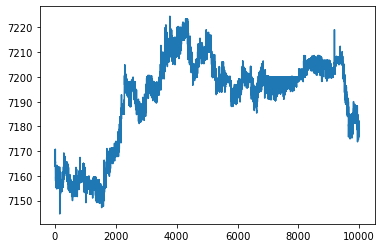

In [11]:
plt.plot(data.price_high, '-')

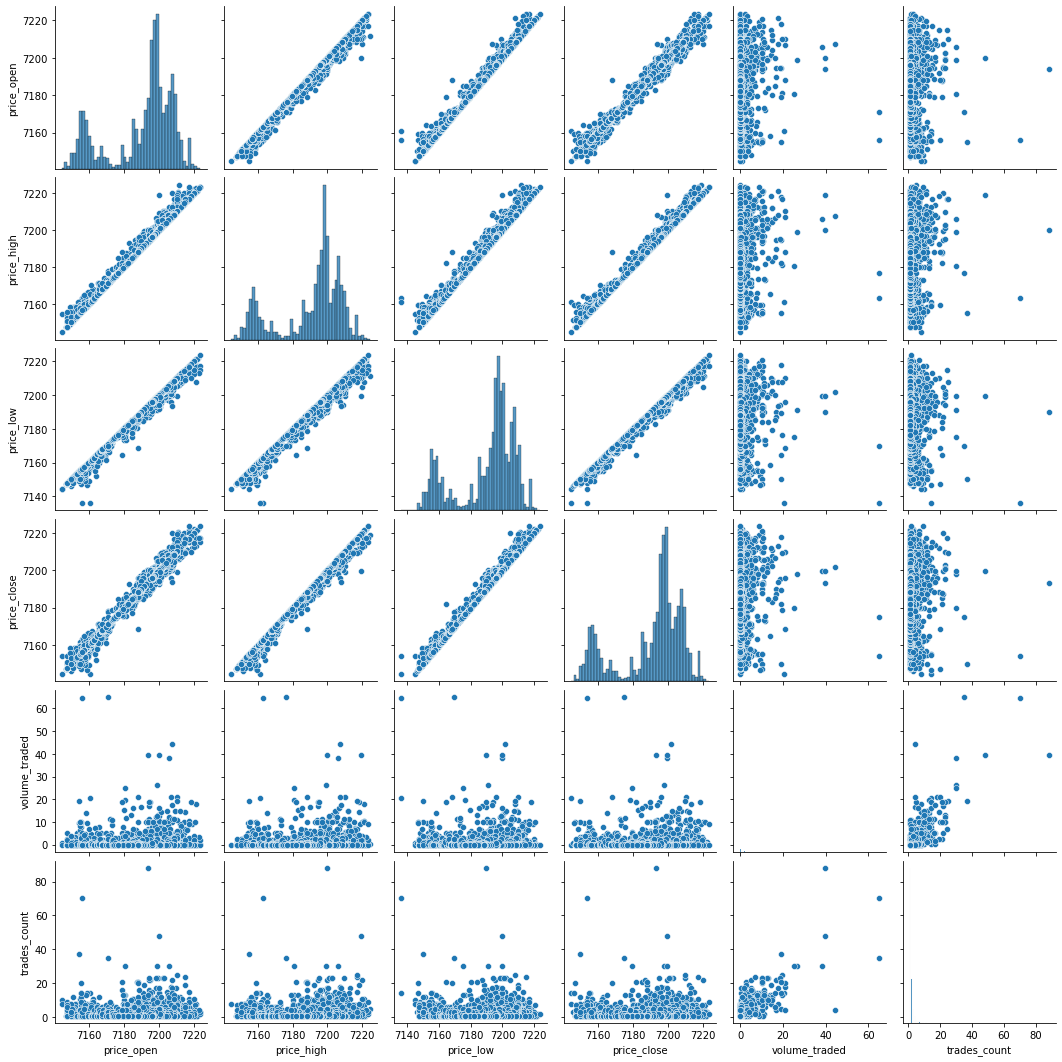

In [12]:
sns.pairplot(data)

In [13]:
data.corr()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
price_open,1.000000,0.998608,0.998470,0.997648,-0.004381,-0.024117
price_high,0.998608,1.000000,0.997007,0.998475,0.008897,-0.003721
price_low,0.998470,0.997007,1.000000,0.998630,-0.024945,-0.047344
price_close,0.997648,0.998475,0.998630,1.000000,-0.010547,-0.027328
volume_traded,-0.004381,0.008897,-0.024945,-0.010547,1.000000,0.744673
trades_count,-0.024117,-0.003721,-0.047344,-0.027328,0.744673,1.000000


## Q: "Does this data set even make sense?" 
All of the price variables in the data set are strongly correlated to eachother, including the variable we are trying to predict. I don't actually even know what all different prices mean. 

On the other end, trading information (`volume_traded` and `trades_count` have little correlation for the price. At least to the current price, but they may be more predictive of the future price over time. 

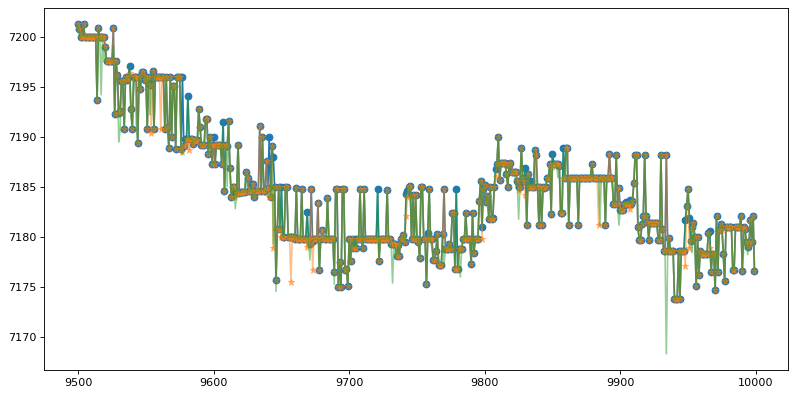

In [14]:
plt.figure(figsize = (12, 6), dpi = 80)
plt.plot(data.price_high[-500:], '-o')
plt.plot(data.price_open[-500:], '-*', alpha=0.5)
plt.plot(data.price_close[-500:], '-', alpha=0.5)

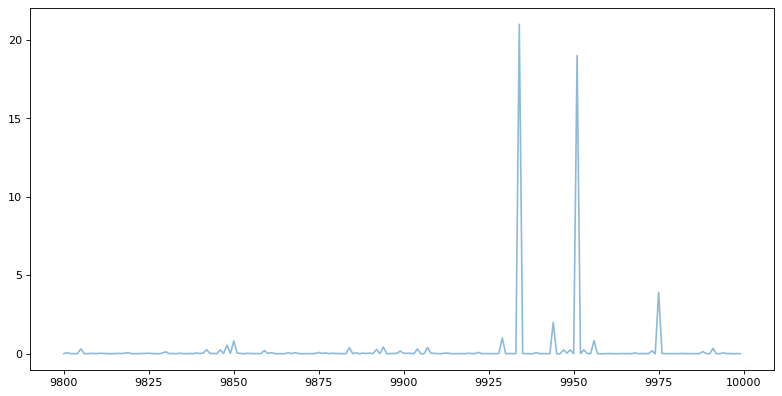

In [15]:
plt.figure(figsize = (12, 6), dpi = 80)
plt.plot(data.volume_traded[-200:], '-', alpha=0.5)

## Q: "Is the lookback window of 60 seconds helpful?"
From the plots above, there seems to be a lot of noise in the short time period, and the price frequently jumps +-5 or more from one second to the next. It may be good to use a moving average instead, which would smooth out some of that noise.

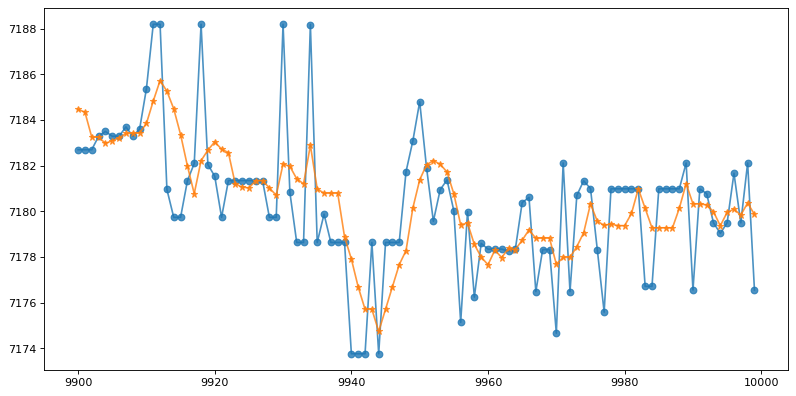

In [54]:
data_avg = pd.DataFrame()
data_avg['price_high'] = data['price_high']
data_avg['price_high_avg'] = data.price_high.rolling(window=5, min_periods=1, center=False).mean() 
# center is False becasue we can't "steal" information from the future, which gives the "lag" to the moving averge
data_avg['volume_traded'] = data.price_high.rolling(window=5, min_periods=1, center=False).mean()
data_avg['trades_count'] = data.price_high.rolling(window=5, min_periods=1, center=False).mean()
plt.figure(figsize = (12, 6), dpi = 80)
plt.plot(data_avg.price_high[-100:], '-o', alpha=0.8)
plt.plot(data_avg.price_high_avg[-100:], '-*', alpha=0.8)

## Q: "If you stuck with the neural network, what did you change to make it better?"
The final output layer should have a different activation function. ReLu is normally used from hidden layers, and here we are trying to predict a numerical value, so a linear layer would be better. 

In [69]:
features = lookback(data_avg)

In [70]:
### split data into features and target
target = features['price_high'].values
features = features.drop('price_high', axis=1).values

In [71]:
def model_test(feat, y):
    model = Sequential()
    model.add(Dense(32, input_dim=feat.shape[1]))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(1, activation='linear'))

    model.compile(
        loss='mse',
        optimizer=Adam(lr=0.001),
        metrics=['mean_squared_error', 'mean_absolute_error'] 
    )

    ## callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        mode='auto',
        restore_best_weights=True
    )


    history = model.fit(
        feat,
        y,
        validation_split=.3,
        epochs=40,
        verbose=0
    )
    ## prediction
    predictions = model.predict(feat)
    rmse = np.sqrt(np.mean(np.square((y.reshape(-1, 1) - predictions))))
    print(rmse)
    
model_test(features, target)

/home/ivanaseric/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


311/311 [==============================] - 0s 555us/step
3.680495671558412


That seems much better than the first model, while at the same time using much less features. 

In [72]:
features = lookback(data_avg, timesteps=120)
target = features['price_high'].values
features = features.drop('price_high', axis=1).values

In [75]:
model_test(features, target)

309/309 [==============================] - 0s 571us/step
4.431923375143157


Re-running the model returns different root mean square error, so it's not clear if adding more backward data is helping the model. We probably should have set the seed at the begining. 

However, the RMSE is more stable for the model with only 60 timesteps. This may be an interesting point to investigate. 

## Q: "How do we know the model is good?"
First, we should divide the data to train and test set to really evaluate how well the model performs on the out of sample data.

Second, the margin of acceptable error depends on the application of the model. How much error can we tolerate? There is a cost accosiated with spending more time to have a better model, or computational cost of having a more complext model, and this cost will have to be considered and compared to the cost of having "worse" predicitons. 

## Q: If we see data for more than a single day's worth of prices, how do we expect the model to perform?
I think this depends on the behavior of the price: is there a pattern in how the price changes based on the time of the day? This information may be helpful for the model to capture larger scale trends in the price. However, we may want to consider using time-series models then as well if we are interested in those trends. 

If we are only trying to predict the price in the next second, this may not be that helpful, and it will cause the model to take a long time to train, which is an important problem if we want to update the model each second by using the newest data available. 